In [1]:
%load_ext autoreload
%autoreload 2
from utils import *
from IPython.display import display, HTML
ins = BrainSpan()

In [2]:
gtex = pd.read_csv("../data/GTEx/GTEx.RecGenes.exon.rpkm.csv")
Exons = pd.read_csv("../data/GTEx/gencode.v19.genes.v7.patched_contigs.exons.txt", delimiter="\t")
Genes = pd.read_csv("../data/GTEx/GTEx.RecGenes.gene.rc.csv")
Samples = pd.read_csv("../data/GTEx/GTEx_v7_Annotations_SampleAttributesDS.txt", delimiter="\t")
Samples = Samples[Samples["SAMPID"].isin(Genes.columns.values)]

/Users/jiayao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
print(Genes.columns.values)

In [ ]:
gtex.head(2)

In [ ]:
RecGenes = set(gtex["Description"].values)
RecGenesEns = set(Genes["Name"].values)
samples = Samples["SAMPID"].values

In [ ]:
for gene in list(RecGenes):
    print(gene)
    exon_dat, gene_dat = [], []
    for sp in samples:
        if sp not in set(Genes.columns):
            continue
        gene_sp_rc = Genes[Genes["Description"]==gene][sp].values[0]
        exon_sp_rc = sum(gtex[gtex["Description"]==gene][sp].values)
        exon_dat.append(exon_sp_rc)
        gene_dat.append(gene_sp_rc)
    plt.scatter(exon_dat, gene_dat)
    plt.show()
    #print(gene)

In [ ]:
for l in open("../data/GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_reads.gct"):
    if l.startswith("Name"):
        samples = l.strip().split("\t")[2:]
        res = [0]*len(samples)
    else:
        llist = [float(x) for x in l.strip().split("\t")[2:]]
        for i in range(len(llist)):
            res[i] += float(llist[i])

In [ ]:
print(len(res))

In [ ]:
outfile = open("../data/GTEx.sample.total.readcount.txt", 'wt')
for sp, value in zip(samples, res):
    outfile.write("{}\t{}\n".format(sp, value))

In [3]:
# summerize gene length and exon length

gtx_exon = pd.read_csv("../data/GTEx/gencode.v19.genes.v7.patched_contigs.exons.txt", delimiter="\t")
gtx_exon["Gene"] = gtx_exon.apply(lambda row:row["exon_id"].split("_")[0].split(".")[0], axis=1)
gtx_exon["ExonLength"] = gtx_exon["end_pos"] - gtx_exon["start_pos"]

In [4]:
gtx_exon.head(2)

,exon_id,chr,start_pos,end_pos,strand,Gene,ExonLength
0,ENSG00000223972.4_1,1,11869,12227,+,ENSG00000223972,358
1,ENSG00000223972.4_2,1,12595,12721,+,ENSG00000223972,126


In [5]:
ALL_GENES = set(gtx_exon["Gene"].values)

In [6]:
Exon2Length = dict(zip(gtx_exon["exon_id"].values, gtx_exon["ExonLength"].values))

In [7]:
Ens2Length = {}
for gene in list(ALL_GENES):
    df = gtx_exon[gtx_exon["Gene"]==gene]
    Ens2Length[gene] = sum(df["ExonLength"].values)

KeyboardInterrupt: 

In [30]:
fin = open("../data/GTEx/GTEx.sample.total.readcount.txt", 'rt')
SP2Libsize = {}
for l in fin:
    sp, libsize = l.split("\t")
    SP2Libsize[sp] = float(libsize)

In [31]:
#GeneRC2RPKM(SP2Libsize, Ens2Length)
ExonRC2RPKM(SP2Libsize, Exon2Length)

/Users/jiayao/Work/BrainDisorders/src/utils.py:2754: RuntimeWarning: invalid value encountered in double_scalars
  return (ReadCount * 1e9) / (Libsize*Length)


In [34]:
GeneRPKM = pd.read_csv("../data/GTEx/GTEx_180Indiv_gene_rpkm.txt", delimiter="\t")
ExonRPKM = pd.read_csv("../data/GTEx/GTEx_180Indiv_exon_rpkm.txt", delimiter="\t")

In [ ]:
ALL_EXON_REL = []#[np.mean(ALLSameExon)]
ALL_GENE_ZSCORE = []#[np.mean(ALLDiffExon)]
Tissues = ["Brain", "Blood", "Skin", "Heart", "Lung"]
for Tissue in Tissues:
    all_exon_rel, all_gene_zscore = RelativeExonExp2GeneExp(GeneRPKM, SelectedTissueSamples, 
                                                        ExonRPKM, GTEx_LGDs, Genes, Tissue)
    ALL_EXON_REL.append(all_exon_rel)
    ALL_GENE_ZSCORE.append(all_gene_zscore)

In [ ]:
x, y = [x for x in ALL_EXON_REL[1]], ALL_GENE_ZSCORE[1]
X = sorted(zip(x,y), key=lambda x:x[1])
x = [x for x,y in X]
y = [y for x,y in X]
plt.scatter(x, y, s=2)
plt.xlim((0,5))
#plt.ylim((-3,5))
yMA = movingaverage(x,100)

print(len(x), len(y), len(yMA))
#plt.plot(x, yMA,"r")
#plt.xscale('log')
plt.show()

In [58]:
Tissue = "Blood"
Genes = list(set(GTEx_LGDs["SEVERE_GENE"].values))
ALL_EXON_REL, ALL_GENE_ZSCORE = RelativeExonExp2GeneExp(GeneRPKM, SelectedTissueSamples, 
                                                        ExonRPKM, GTEx_LGDs, Genes, Tissue)
print(spearmanr(ALL_EXON_REL, ALL_GENE_ZSCORE))

SpearmanrResult(correlation=0.022414106116276075, pvalue=0.19806952101153416)


SpearmanrResult(correlation=0.022414106116276075, pvalue=0.19806952101153416)


/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log2
  This is separate from the ipykernel package so we can avoid doing imports until


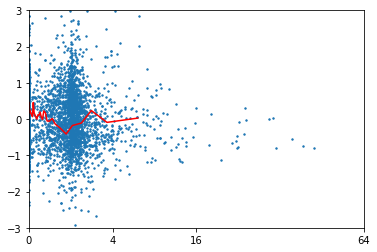

In [67]:
plt.scatter([math.log2(x+1) for x in ALL_EXON_REL], ALL_GENE_ZSCORE, s=2)
print(spearmanr([math.log2(x+1) for x in ALL_EXON_REL], ALL_GENE_ZSCORE))
X_, Y_ = MyMovingAVG(np.log2(ALL_EXON_REL), ALL_GENE_ZSCORE, 50)
#plt.scatter((ALL_EXON_REL), ALL_GENE_ZSCORE, s=2)
#X_, Y_ = MyMovingAVG((ALL_EXON_REL), ALL_GENE_ZSCORE, 200)
plt.plot(X_, Y_, color="red")
plt.xlim((0,5))
plt.ylim((-3,3))
#plt.axhline(y=0, color='black')
#plt.xscale('log')
Xs = [0,2,4,8]
plt.xticks(Xs, [x**2 for x in Xs])
plt.show()

In [344]:
Tissue = "Blood"
Genes = list(set(GTEx_LGDs["SEVERE_GENE"].values))
ALL_EXON_REL2, ALL_GENE_ZSCORE2 = RelativeExonExp2GeneExp(GeneRPKM, SelectedTissueSamples, 
                                                        ExonRPKM, GTEx_LGDs, Genes, Tissue)
print(spearmanr(ALL_EXON_REL, ALL_GENE_ZSCORE))

SpearmanrResult(correlation=-0.3565357786366686, pvalue=2.324472647713114e-137)


SpearmanrResult(correlation=-0.04642831202261601, pvalue=0.0008035454070568649)


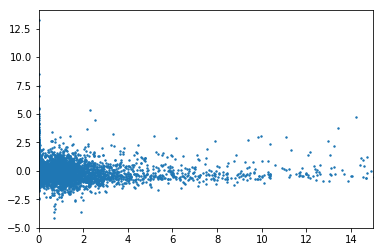

In [346]:
print(spearmanr(ALL_EXON_REL2, ALL_GENE_ZSCORE2))
plt.scatter(ALL_EXON_REL2, ALL_GENE_ZSCORE2, s=2)
plt.xlim((0,15))
#plt.xscale('log')
plt.show()

SpearmanrResult(correlation=-0.24733932289788566, pvalue=2.1187980552779866e-73)


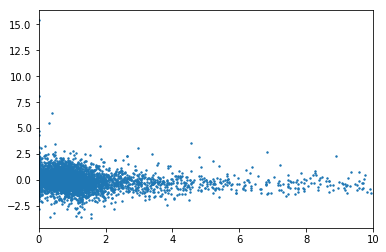

In [330]:
Tissue = "Skin"
Genes = list(set(GTEx_LGDs["SEVERE_GENE"].values))
ALL_EXON_REL, ALL_GENE_ZSCORE = RelativeExonExp2GeneExp(GeneRPKM, SelectedTissueSamples, 
                                                        ExonRPKM, GTEx_LGDs, Genes, Tissue)
plt.scatter(ALL_EXON_REL, ALL_GENE_ZSCORE, s=2)
plt.xlim((0,10))
print(spearmanr(ALL_EXON_REL, ALL_GENE_ZSCORE))

SpearmanrResult(correlation=0.01743405565216179, pvalue=0.6096577497347915)


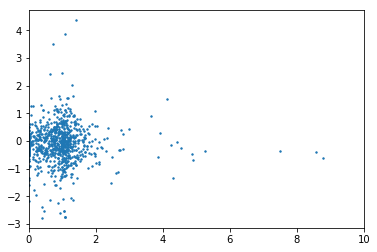

In [56]:
Tissue = "Brain"
Genes = list(set(GTEx_LGDs["SEVERE_GENE"].values))
ALL_EXON_REL, ALL_GENE_ZSCORE = RelativeExonExp2GeneExp(GeneRPKM, SelectedTissueSamples, 
                                                        ExonRPKM, GTEx_LGDs, Genes, Tissue)
plt.scatter(ALL_EXON_REL, ALL_GENE_ZSCORE, s=2)
plt.xlim((0,10))
print(spearmanr(ALL_EXON_REL, ALL_GENE_ZSCORE))

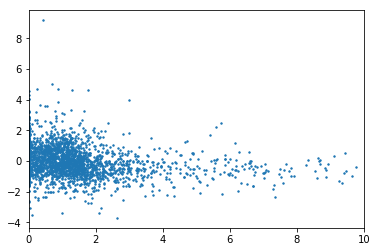

SpearmanrResult(correlation=-0.29613493198580176, pvalue=4.187435038002678e-55)


In [329]:
Tissue = "Heart"
Genes = list(set(GTEx_LGDs["SEVERE_GENE"].values))
ALL_EXON_REL, ALL_GENE_ZSCORE = RelativeExonExp2GeneExp(GeneRPKM, SelectedTissueSamples, 
                                                        ExonRPKM, GTEx_LGDs, Genes, Tissue)
plt.scatter(ALL_EXON_REL, ALL_GENE_ZSCORE, s=2)
plt.xlim((0,10))
ax.set_yscale('log')
plt.show()
print(spearmanr(ALL_EXON_REL, ALL_GENE_ZSCORE))

In [239]:
L1, L2 = [], []
for x,y in zip(ALL_EXON_REL, ALL_GENE_ZSCORE):
    if x == x and y == y:
        L1.append(x)
        L2.append(y)
print(spearmanr(L1, L2))
print(pearsonr(L1, L2))

SpearmanrResult(correlation=-0.29613493198580176, pvalue=4.187435038002678e-55)
(nan, 1.0)


In [ ]:
#Samples.groupby("SMTS").count()["SAMPID"]
# Brain, Blood, Skin
BrainSamples = Samples[Samples["SMTS"]=="Brain"]["SAMPID"].values
BloodSamples = Samples[Samples["SMTS"]=="Blood"]["SAMPID"].values
SkinSamples = Samples[Samples["SMTS"]=="Skin"]["SAMPID"].values

In [ ]:
# Get Gene RPKM
GeneRC = pd.read_csv("../data/GTEx.RecGenes.gene.rc.csv")
GeneRC.set_index("Name", inplace=True)
for SP in GeneRC.columns.values[1:]:
    for gene in GeneRC.index.values:
        #rint(GeneRC.loc[gene, SP])
        GeneRC.loc[gene, SP] = round(RPKM(GeneRC.loc[gene, SP], Ens2Length[gene], SP2Libsize[SP]), 2)
GeneRC.to_csv("../data/GTEx.RecGenes.gene.rpkm.csv", index="False")

In [ ]:
# Get Exon RPKM
ExonRC = pd.read_csv("../data/GTEx.RecGenes.exon.rc.csv")
ExonRC.set_index("Name", inplace=True)
for SP in ExonRC.columns.values[1:]:
    for exon in ExonRC.index.values:
        ExonRC.loc[exon, SP] = round(RPKM(ExonRC.loc[exon, SP], Exon2Length[exon], SP2Libsize[SP]), 2)
ExonRC.to_csv("../data/GTEx.RecGenes.exon.rpkm.csv", index="False")

In [ ]:
GeneRPKM = pd.read_csv("../data/GTEx.RecGenes.gene.rpkm.csv")
GeneRPKM.set_index("Name", inplace=True)
GeneRPKM.head(2)

In [33]:
ExonRPKM = pd.read_csv("../data/GTEx.RecGenes.exon.rpkm.csv")
ExonRPKM.set_index("Name", inplace=True)
ExonRPKM.head(2)

FileNotFoundError: File b'../data/GTEx.RecGenes.exon.rpkm.csv' does not exist

In [ ]:
print(BrainSamples)

In [ ]:
# GeneExpinTissues
BrainExp = GeneRPKM[BrainSamples]
BloodExp = GeneRPKM[BloodSamples]
SkinExp = GeneRPKM[SkinSamples]

Tissue2Exp = {}
Tissue2Exp["Brain"] = (GeneRPKM[["Description"]+list(BrainSamples)], ExonRPKM[["Description"]+list(BrainSamples)])
Tissue2Exp["Blood"] = (GeneRPKM[["Description"]+list(BloodSamples)], ExonRPKM[["Description"]+list(BloodSamples)])
Tissue2Exp["Skin"]  = (GeneRPKM[["Description"]+list(SkinSamples)], ExonRPKM[["Description"]+list(SkinSamples)])

In [ ]:
Tissue2Exp["Brain"][1].head(2)

In [ ]:
Gene = "ENSG00000136531.9"
Gene = "ENSG00000114861.14"
Gene = "ENSG00000157540.15"
ax = plt.subplot(111)
pos = [1,2,3]
plt.violinplot([BrainExp.loc[Gene,:].values, BloodExp.loc[Gene,:].values, SkinExp.loc[Gene,:].values], pos)
ax.set_xticks(pos)
ax.set_xticklabels(["Brain", "Blood", "Skin"])
plt.xlabel
plt.show()

In [ ]:
Jiayao_features = pd.read_csv("unifiedmodel/features.jiayao.65.csv")
Variants = Jiayao_features[['familyId', 'vcfVariant', 'inChild', 'effectGene', 'effectType',
       'gender', 'VIQ', 'NVIQ', 'Age',]]
Variants.loc[Variants["effectGene"]=="MLL5", "effectGene"] = "KMT2E" #MLL5 
Variants.columns

In [ ]:
Gene2Ens = pd.read_csv("../data/GTEx.ENSG2SYMBOL.txt", delimiter="\t", names=[1,2])
Gene2Ens = dict(zip(Gene2Ens[2].values, Gene2Ens[1].values))

In [ ]:
def sudogmean(values):
    values = [(x+1) for x in values]
    gmean = scipy.stats.mstats.gmean(values)
    return gmean-1
def searchExon(Gene, Chr, Pos, Ref, Alt, ExonRow):
    Pos, LenV = int(Pos), len(Ref)-len(Alt)
    ExonRow = ExonRow[ExonRow["Gene"]==Gene2Ens[Gene]]
    for i, row in ExonRow.iterrows():
        exon_id, start, end = row["exon_id"],int(row["start_pos"]),int(row["end_pos"])
        if Pos > start -3 and Pos < end + 3:
            return exon_id
        elif LenV > 0: # a delition may span a splice site
            if (Pos < start-3 and Pos + LenV > start ) or (Pos < end and Pos + LenV > end +3):
                return exon_id
    return 0

Variants["ExonID"] = 0
for Tissue in ["Brain", "Blood", "Skin"]:
    Variants["%sGeneExp.amean"%Tissue] = 0.0
    Variants["%sGeneExp.gmean"%Tissue] = 0.0
    Variants["%sExonExp.amean"%Tissue] = 0.0
    Variants["%sExonExp.gmean"%Tissue] = 0.0
for i, row in Variants.iterrows():
    famid, gene, (Chr, Pos, Ref, Alt) = row["familyId"], row["effectGene"], row["vcfVariant"].split(":")
    #ens = Ens2Gene(gene)
    try:
        Variants.loc[i, "Age"] = famid2age[str(famid)]
    except:
        Variants.loc[i, "Age"] = 0
    try:
        #GeneExp = GeneRPKM[GeneRPKM["Description"]==gene]
        for Tissue in ["Brain", "Blood", "Skin"]:
            df = Tissue2Exp[Tissue][0]
            #TissueExp = df.loc[Gene,:]
            TissueExp = df[df["Description"]==gene].values[0][1:]
            gene_nmean, gene_gmean = np.mean(TissueExp), sudogmean(TissueExp)
            Variants["%sGeneExp.amean"%Tissue] = gene_nmean
            Variants["%sGeneExp.gmean"%Tissue] = gene_gmean
    except IndexError:
        print("gene not find", famid, gene)
    
    exonId = searchExon(gene, Chr, Pos, Ref, Alt, gtx_exon)
    
    if len(Ref) == len(Alt):
        Variants.loc[i, "KEY"] = "%s-%s:%d"%(famid, Chr, int(Pos))
    else:
        Variants.loc[i, "KEY"] = "%s-%s:%d"%(famid, Chr, int(Pos)+1)
    if exonId != 0:
        Variants.loc[i, "ExonID"] = exonId
        
        for Tissue in ["Brain", "Blood", "Skin"]:
            df = Tissue2Exp[Tissue][1]
            TissueExp = df[df.index==exonId].values[0][1:]
            exon_nmean, exon_gmean = np.mean(TissueExp), sudogmean(TissueExp)
            Variants.loc[i, "%sExonExp.amean"%Tissue] = exon_nmean
            Variants.loc[i, "%sExonExp.gmean"%Tissue] = exon_gmean
            Variants.loc[i, "%sRel.exp.amean"%Tissue] = exon_nmean/Variants.loc[i, "%sGeneExp.amean"%Tissue]
            Variants.loc[i, "%sRel.exp.gmean"%Tissue] = exon_gmean/Variants.loc[i, "%sGeneExp.gmean"%Tissue]
    else:
        print("exon not find", famid, gene)

In [ ]:
print(Variants.shape)
Variants.head()
Variants.to_csv("../data/GTEx.2Tissue.Pred.65.csv", index=False)

In [ ]:
Tissue = "Brain"
gene2slope = {}
ALL_RelExp = np.array([])
ALL_Normed_IQD = np.array([])
Genes = list(set(Variants["effectGene"].values))
for gene in Genes:
    df = Variants[Variants["effectGene"]==gene]
    IQs = [max(0, (100-x)) for x in df["NVIQ"].values]
    #rel_exps = [x for x in df["Rel.exp.amean"].values] #Rel.exp.prenatal
    #rel_exps = [x for x in df["Rel.exp.prenatal"].values] #Rel.exp.prenatal
    rel_exps = [x for x in df["%sRel.exp.amean"%Tissue].values]
    regr = regGene(rel_exps, IQs)
    slope = regr.coef_[0]
    #if slope == 0:
    #    continue
    gene2slope[gene] = slope
    ALL_RelExp = np.append(ALL_RelExp, rel_exps)
    NormIQDs = np.array([x/slope for x in IQs])
    ALL_Normed_IQD = np.append(ALL_Normed_IQD, NormIQDs)

In [ ]:
model = linear_model.LinearRegression(fit_intercept=False)
ALL_RelExp = ALL_RelExp.reshape(-1,1)
R, P = scipy.stats.pearsonr([x[0] for x in ALL_RelExp], ALL_Normed_IQD) 
R, P = scipy.stats.spearmanr([x[0] for x in ALL_RelExp], ALL_Normed_IQD) 
plt.figure(figsize=(4,4), dpi=120)
plt.title("Relative expression of exon containing LGD mutation")
model.fit(ALL_RelExp, ALL_Normed_IQD)
plt.scatter(ALL_RelExp, ALL_Normed_IQD, s=40, facecolors='none', edgecolors='black')
plt.plot([0, 5], [0,model.predict([[5.0]])], color='red')
plt.text(0, 2.7, "R=%.3f"%(R))
#plt.xlim((0,5))
#plt.ylim((0,5))
plt.show()

In [ ]:
Variants = pd.read_csv("../data/GTEx.2Tissue.Pred.65.csv")
ExcludeList = ["13398-1:151377904", "13627-1:151378489", "13664-1:202698172", "13447-6:157527665", 
               "12323-9:96439930", "13545-20:49509095", "12130-20:49510028", "12764-2:183791570", "13735-21:41414331"]
Variants = Variants[~Variants["familyId"].isin(ExcludeList)]
GTExDosagePredErrs = {}
for Tissue in ["Brain", "Blood", "Skin"]:
    IQ_diff1, IQ_diff2, IQ_diff3 = [], [], []
    avg_IQ = np.mean(Variants["NVIQ"].values)
    N = 0
    for i, row in Variants.iterrows():
        familyId, gene, ralexp, IQ = row["familyId"], row["effectGene"], row["%sRel.exp.gmean"%Tissue], row["NVIQ"]
        df = Variants[(Variants["effectGene"]==gene) & (Variants["familyId"]!=familyId)]
        IQs = df["NVIQ"].values
        IQDiffs = [max(0, (100-x)) for x in IQs]
        rel_exps = [x for x in df["%sRel.exp.gmean"%Tissue].values]
        regr = regGene(rel_exps, IQDiffs)
        slope = regr.coef_[0]
        IQpre_dosage = max(0, (100 - slope * ralexp))

        IQpre_gene = np.mean(IQs)
        if abs(IQ - IQpre_dosage) > 50:
            pass
            #print(familyId, gene, IQ, IQpre_dosage, ralexp)
        IQ_diff1.append(abs(IQ - IQpre_dosage))
        IQ_diff2.append(abs(IQ - IQpre_gene))
        IQ_diff3.append(abs(IQ - 70))
        N += 1
    plt.figure(figsize=(4,4), dpi=120)
    plt.boxplot([IQ_diff1, IQ_diff2, IQ_diff3], labels = ["dosamge", "gene", "mean"])
    GTExDosagePredErrs[Tissue] = IQ_diff1
    plt.ylabel("Nonverbal IQ difference")
    plt.grid(True)
    print(Tissue, np.median(IQ_diff1), np.mean(IQ_diff1))
    plt.show()

In [ ]:
print(scipy.stats.mannwhitneyu(GTExDosagePredErrs["Brain"], GTExDosagePredErrs["Blood"], alternative="less"))
print(scipy.stats.mannwhitneyu(GTExDosagePredErrs["Brain"], GTExDosagePredErrs["Skin"], alternative="less"))

In [ ]:
print(scipy.stats.wilcoxon(GTExDosagePredErrs["Brain"], GTExDosagePredErrs["Blood"]))
print(scipy.stats.wilcoxon(GTExDosagePredErrs["Brain"], GTExDosagePredErrs["Skin"]))

In [38]:
INDELs = pd.read_csv("../data/GTEx/GTEx_Data_20140613_ExomeSeq_180Indiv_GATK_HC_indels_annot.tsv", delimiter="\t")
SNVs = pd.read_csv("../data/GTEx/GTEx_Data_20140613_ExomeSeq_180Indiv_GATK_UG_SNPs_annot.tsv", delimiter="\t")
GTEx_LGDs = pd.concat([INDELs, SNVs])
GTEx_LGDs = GTEx_LGDs[(GTEx_LGDs["SEVERE_IMPACT"]!="SPLICE_REGION_VARIANT") & 
                      (GTEx_LGDs["GT"]=="0/1")]

In [39]:
GTEx_LGDs.head(2)

,CHR,POS,REF,ALT,AF,SEVERE_GENE,SEVERE_GENE_NAME,SEVERE_IMPACT,INDV,GT,DP,GQ
2,1,905784,TG,T,0.002778,ENSG00000187583,PLEKHN1,FRAMESHIFT_VARIANT,GTEX-T5JW-0002-SM-3UZEZ,0/1,15,99.0
4,1,984430,TGCAGCTCAGGTGGGCGGGGAGGGGACGGGGCCGGGGCAGCTCAGG...,T,0.002890,ENSG00000188157,AGRN,SPLICE_DONOR_VARIANT,GTEX-X585-0003-SM-3USRA,0/1,14,99.0


In [40]:
# Annotation with Exons from Gencodev19

GeneCount = GTEx_LGDs.groupby("SEVERE_GENE_NAME")["SEVERE_GENE_NAME"].count()
GTEx_LGDs["GeneCount"] = GTEx_LGDs.apply(lambda row: GeneCount[row["SEVERE_GENE_NAME"]], axis=1)
GTEx_LGDs = GTEx_LGDs[GTEx_LGDs["GeneCount"]>=2]
gtex_lgd_genes = set(GTEx_LGDs["SEVERE_GENE_NAME"].values)
#GTEx_LGDs

In [41]:
GTFGeneTransExon = {}
EnsemblMapper = {}
hand = open("../data/GTEx/GTEx.RecLGDgenes.gencode.v19.gtf", 'rt')
for l in hand:
    if l.startswith("#"):
        continue
    llist = l.strip().split("\t")
    info = gtf_info_parser(llist[8]) 
    CHR = llist[0].lstrip("chr")
    strand = llist[6]
    start = int(llist[3])
    end = int(llist[4])
    if llist[2] == "gene":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"]
        EnsemblMapper[gene_id.split(".")[0]]=gene_id
        GTFGeneTransExon[gene_name] = GTFGene(gene_name, gene_id, strand)
    elif llist[2] == "transcript":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"]
        transcript_name = info["transcript_id"]
        transcript_id = info["transcript_id"]
        transcript_type = info["transcript_type"]
        if transcript_id not in GTFGeneTransExon[gene_name].Transcripts and transcript_type=="protein_coding":
            GTFGeneTransExon[gene_name].Transcripts[transcript_id] = GTFTranscript(gene_name, transcript_name, transcript_id, strand)
    elif llist[2] == "exon":
        gene_name = info["gene_name"]
        gene_id = info["gene_id"]
        exon_id = info["exon_id"]
        transcript_name = info["transcript_id"]
        transcript_id = info["transcript_id"]
        transcript_type = info["transcript_type"]
        if transcript_type=="protein_coding":
            exon= GTFExon(exon_id, start, end, transcript_id, strand)
            GTFGeneTransExon[gene_name].Transcripts[transcript_id].Exons.append(exon)
        

AttributeError: 'dict' object has no attribute 'append'

In [45]:
def searchExon(Gene, Pos, Ref, Alt, Genes):
    Pos, LenV = int(Pos), len(Ref)-len(Alt)
    gene_obj = Genes[Gene]
    _Exons, Transcripts = [],[]
    for transid, transobj in gene_obj.Transcripts.items():
        for exon in transobj.Exons:
            if Pos > exon.start -3 and Pos < exon.end +3:
                _Exons.append(exon.ExonID)
                Transcripts.append(transid)
                break
            elif LenV > 0:
                if (Pos < exon.start-3 and Pos + LenV > exon.start ) or (Pos < exon.end and Pos + LenV > exon.end +3):
                    _Exons.append(exon.ExonID)
                    Transcripts.append(transid)
                    break
    #return list(set(_Exons)), list(set(Transcripts))
    return ";".join(_Exons), ";".join(Transcripts)

In [46]:
GTEx_LGDs.head(2)

,CHR,POS,REF,ALT,AF,SEVERE_GENE,SEVERE_GENE_NAME,SEVERE_IMPACT,INDV,GT,DP,GQ,GeneCount,Exons,Transcripts,GTExExonID
5,1,1115544,A,AC,0.002778,ENSG00000162571,TTLL10,FRAMESHIFT_VARIANT,GTEX-T5JW-0002-SM-3UZEZ,0/1,9,99.0,4,,,ENSG00000162571.9_3
6,1,1116222,C,CG,0.011000,ENSG00000162571,TTLL10,FRAMESHIFT_VARIANT,GTEX-R55E-0003-SM-3UZFL,0/1,9,44.0,4,,,ENSG00000162571.9_5


In [47]:
GTEx_LGDs["Exons"] = ""
GTEx_LGDs["Transcripts"] = ""
GencodeMissingGene = []
for i, row in GTEx_LGDs.iterrows():
    Chr, Pos, Ref, Alt, gene = row["CHR"], row["POS"], row["REF"], row["ALT"], row["SEVERE_GENE_NAME"]
    if gene in GTFGeneTransExon:
        ExonIDs, TranscriptIDs = searchExon(gene, Pos, Ref, Alt, GTFGeneTransExon)
        GTEx_LGDs.loc[i, "Exons"] = ExonIDs
        GTEx_LGDs.loc[i, "Transcripts"] = TranscriptIDs
    else:
        GencodeMissingGene.append(gene)

In [48]:
GTEx_LGDs["GTExExonID"] = ""
for i, row in GTEx_LGDs.iterrows():
    Chr, Pos, Ref, Alt, gene = row["CHR"], row["POS"], row["REF"], row["ALT"], row["SEVERE_GENE"]
    GTExExonID = searchExon_GTExExon(gene, Pos, Ref, Alt, gtx_exon)
    GTEx_LGDs.loc[i, "GTExExonID"] = GTExExonID

In [49]:
GTEx_LGDs.head(2)

,CHR,POS,REF,ALT,AF,SEVERE_GENE,SEVERE_GENE_NAME,SEVERE_IMPACT,INDV,GT,DP,GQ,GeneCount,Exons,Transcripts,GTExExonID
5,1,1115544,A,AC,0.002778,ENSG00000162571,TTLL10,FRAMESHIFT_VARIANT,GTEX-T5JW-0002-SM-3UZEZ,0/1,9,99.0,4,,,ENSG00000162571.9_3
6,1,1116222,C,CG,0.011000,ENSG00000162571,TTLL10,FRAMESHIFT_VARIANT,GTEX-R55E-0003-SM-3UZFL,0/1,9,44.0,4,,,ENSG00000162571.9_5


In [12]:
#GTEx_LGDs.to_csv("../data/GTEx/GTEx.RecLGD.annoGencode.tsv", sep="\t", index="False")

In [50]:
GTEx_LGDs.shape

(5215, 16)

In [51]:
len(set(GTEx_LGDs["INDV"].values))

180

In [15]:
writer = csv.writer(open("../data/GTEx/180Indiv.list", 'wt'))
for indv in list(set(GTEx_LGDs["INDV"].values)):
    writer.writerow([indv])

In [16]:
Doners = set([x.split("-")[1] for x in GTEx_LGDs["INDV"].values])
#Doners

In [24]:
Exp_samples = [l.strip() for l in open("../data/GTEx/180Indiv.EXP.Samples.list")]
Exp_Samples = Samples[Samples["SAMPID"].isin(Exp_samples)]
Exp_Samples["Doner"] = Exp_Samples.apply(lambda row:row['SAMPID'].split("-")[1], axis=1)
Exp_Samples = Exp_Samples[["Doner", "SAMPID", "SMTS", "SMTSD"]]

/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
Exp_Samples.head(2)

,Doner,SAMPID,SMTS,SMTSD
8116,N7MS,GTEX-N7MS-0007-SM-2D7W1,Blood,Whole Blood
8117,N7MS,GTEX-N7MS-0008-SM-4E3JI,Skin,Cells - Transformed fibroblasts


In [26]:
set(Exp_Samples["SMTS"].values)
SelectedTissue = ["Adipose Tissue", "Adrenal Gland", "Brain", "Heart", "Lung",
                  "Muscle", "Nerve", "Skin", "Thyroid", "Blood"]
SelectedTissueSamples = Exp_Samples[Exp_Samples["SMTS"].isin(SelectedTissue)]
SelectedTissueSamples = SelectedTissueSamples[SelectedTissueSamples["SMTSD"]!="'Cells - EBV-transformed lymphocytes'"]
SelectedTissueSamples = SelectedTissueSamples[SelectedTissueSamples["SMTSD"]!="'Cells - EBV-transformed lymphocytes'"]
SelectedTissueSamples.head(2)

,Doner,SAMPID,SMTS,SMTSD
8116,N7MS,GTEX-N7MS-0007-SM-2D7W1,Blood,Whole Blood
8117,N7MS,GTEX-N7MS-0008-SM-4E3JI,Skin,Cells - Transformed fibroblasts


In [ ]:
set(SelectedTissueSamples[SelectedTissueSamples["SMTS"]=="Blood"]["SMTSD"].values)

In [ ]:
GenesWithLGD = list(set(GTEx_LGDs["SEVERE_GENE_NAME"].values))
len(GenesWithLGD)
print(GenesWithLGD[:10])

In [ ]:
GeneTPM = pd.read_csv("../data/GTEx/GTEx_180Indiv_selectedGeneTissue_gene_tpm.txt", delimiter="\t")
GeneTPM.head()

In [33]:
SameExonDat = []#[np.mean(ALLSameExon)]
DiffExonDat = []#[np.mean(ALLDiffExon)]
SameExonErr = []#[np.std(ALLSameExon)/len(ALLSameExon)]
DiffExonErr = []#[np.std(ALLDiffExon)/len(ALLDiffExon)]
Tissues = ["Brain", "Blood", "Skin", "Heart", "Lung"]
for Tissue in Tissues:
    ALLSameExon, ALLDiffExon = [], []
    for EnsGeneID in SELECTED_GENE_ENSID:
        RES = GTExTranscriptSimilarity(TransTPM, GTEx_LGDs, SelectedTissueSamples, EnsGeneID, Tissue)
        if RES != None:
            if RES[0] == RES[0]:
                ALLSameExon.extend(RES[0])
            if RES[1] == RES[1]:
                ALLDiffExon.extend(RES[1])
    #print(np.mean(ALLSameExon), np.mean(ALLDiffExon))
    print(Tissue, np.mean(ALLSameExon), np.mean(ALLDiffExon))
    print(scipy.stats.mannwhitneyu(ALLSameExon, ALLDiffExon))
    SameExonDat.append(np.mean(ALLSameExon))
    DiffExonDat.append(np.mean(ALLDiffExon))
    SameExonErr.append(np.std(ALLSameExon)/len(ALLSameExon))
    DiffExonErr.append(np.std(ALLDiffExon)/len(ALLDiffExon))

/Users/jiayao/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2253: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Ttest_indResult(statistic=-4.370915244793738, pvalue=1.2379255807022882e-05)
-0.0462799336467195 0.002179149344964457


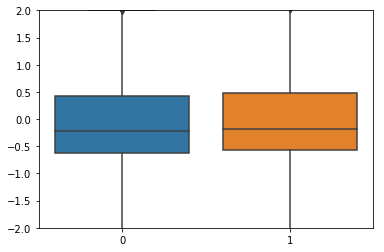

In [35]:
ax = sns.boxplot(data=[L1, L2])
plt.ylim((-2, 2))
print(scipy.stats.ttest_ind(L1, L2))
print(np.mean(L1), np.mean(L2))

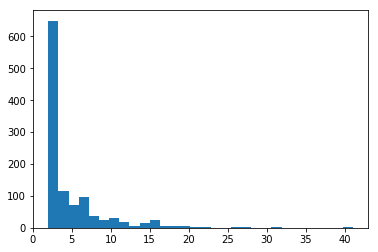

In [36]:
NLGDs = []
for Gene in GenesWithLGD:
    Gene_LGDs = GTEx_LGDs[GTEx_LGDs["SEVERE_GENE_NAME"]==Gene]
    NLGDs.append(Gene_LGDs.shape[0])
plt.hist(NLGDs, bins=30)
plt.show()

In [70]:
TransTPM = pd.read_csv("../data/GTEx/GTEx_180Indiv_transcript_tpm.txt", delimiter="\t")

In [71]:
TransTPM["gene_id_2"] = TransTPM.apply(lambda row:row["gene_id"].split(".")[0], axis=1)
TransTPM.head(2)

,transcript_id,gene_id,GTEX-N7MS-0007-SM-2D7W1,GTEX-N7MS-0008-SM-4E3JI,GTEX-N7MS-0011-R10A-SM-2HMJK,GTEX-N7MS-0011-R11A-SM-2HMJS,GTEX-N7MS-0011-R1a-SM-2HMJG,GTEX-N7MS-0011-R2a-SM-2HML6,GTEX-N7MS-0011-R3a-SM-33HC6,GTEX-N7MS-0011-R4a-SM-2HMKW,...,GTEX-XBED-0126-SM-47JY7,GTEX-XBED-0526-SM-47JY3,GTEX-XBED-0826-SM-47JYC,GTEX-XBED-1326-SM-4AT4F,GTEX-XBED-1926-SM-47JYP,GTEX-XBED-2226-SM-47JYQ,GTEX-XBED-2326-SM-47JYR,GTEX-XBED-2526-SM-47JYD,GTEX-XBED-2626-SM-4E3J5,gene_id_2
0,ENST00000286031,ENSG00000000460,0.0,0.11,0.00,0.00,0.0,0.18,0.00,0.00,...,0.0,0.13,0.0,0.15,0.00,0.00,0.00,0.00,0.00,ENSG00000000460
1,ENST00000359326,ENSG00000000460,0.0,3.50,0.12,0.81,0.0,0.66,0.42,0.14,...,1.1,0.00,0.0,0.62,0.16,0.33,0.47,0.52,0.25,ENSG00000000460


In [108]:
SELECTED_GENE_ENSID = list(set(GTEx_LGDs["SEVERE_GENE"].values))
SELECTED_GENE_ENSID[:5]

['ENSG00000065526',
 'ENSG00000129347',
 'ENSG00000109063',
 'ENSG00000110881',
 'ENSG00000132950']

In [133]:
Tissue="Skin"
SameExonDat = []#[np.mean(ALLSameExon)]
DiffExonDat = []#[np.mean(ALLDiffExon)]
SameExonErr = []#[np.std(ALLSameExon)/len(ALLSameExon)]
DiffExonErr = []#[np.std(ALLDiffExon)/len(ALLDiffExon)]
Tissues = ["Brain", "Blood", "Skin", "Heart", "Lung"]
for Tissue in Tissues:
    ALLSameExon, ALLDiffExon = [], []
    for EnsGeneID in SELECTED_GENE_ENSID:
        RES = GTExTranscriptSimilarity(TransTPM, GTEx_LGDs, SelectedTissueSamples, EnsGeneID, Tissue)
        if RES != None:
            if RES[0] == RES[0]:
                ALLSameExon.extend(RES[0])
            if RES[1] == RES[1]:
                ALLDiffExon.extend(RES[1])
    #print(np.mean(ALLSameExon), np.mean(ALLDiffExon))
    print(Tissue, np.mean(ALLSameExon), np.mean(ALLDiffExon))
    print(scipy.stats.mannwhitneyu(ALLSameExon, ALLDiffExon))
    SameExonDat.append(np.mean(ALLSameExon))
    DiffExonDat.append(np.mean(ALLDiffExon))
    SameExonErr.append(np.std(ALLSameExon)/len(ALLSameExon))
    DiffExonErr.append(np.std(ALLDiffExon)/len(ALLDiffExon))

Brain 0.17294886847475135 0.24864651291309003
MannwhitneyuResult(statistic=38036.0, pvalue=0.0003492669006237531)
Blood 0.33783073040353095 0.3980324898071179
MannwhitneyuResult(statistic=8460147.5, pvalue=8.749560209448133e-18)
Skin 0.2805563074748345 0.3642860199243468
MannwhitneyuResult(statistic=13007921.5, pvalue=9.445743154869425e-41)
Heart 0.3001684801429953 0.3610133990638224
MannwhitneyuResult(statistic=1060094.5, pvalue=3.229249291228592e-07)
Lung 0.2699674621200567 0.3496268802388091
MannwhitneyuResult(statistic=3368280.5, pvalue=3.723792718027589e-18)


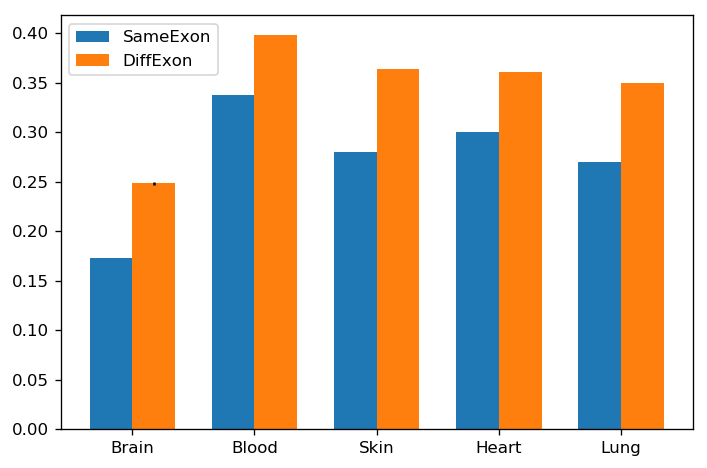

In [134]:
ind = np.arange(len(Tissues))  # the x locations for the groups
width = 0.35  # the width of the bars
fig, ax = plt.subplots(dpi=120)
rects1 = ax.bar(ind - width/2, SameExonDat, width, yerr=SameExonErr,
                label='SameExon')
rects2 = ax.bar(ind + width/2, DiffExonDat, width, yerr=DiffExonErr,
                label='DiffExon')
ax.set_ylabel('')
ax.set_title('')
ax.set_xticks(ind)
ax.set_xticklabels(Tissues)
ax.legend(loc="upper left")
fig.tight_layout()
plt.xticks(rotation=0)
plt.show()

In [12]:
GTEX_LGDs = ['STOP_LOST', 'SPLICE_ACCEPTOR_VARIANT', 'STOP_GAINED', 'SPLICE_DONOR_VARIANT', 
             'INITIATOR_CODON_CHANGE', 'FRAMESHIFT_VARIANT', 'STOP_LOST', 
             'SPLICE_DONOR_VARIANT', 'STOP_GAINED', 'SPLICE_ACCEPTOR_VARIANT']

In [13]:
INDELs = pd.read_csv("../data/GTEx/GTEx_Data_20140613_ExomeSeq_180Indiv_GATK_HC_indels_annot.tsv", delimiter="\t")
SNVs = pd.read_csv("../data/GTEx/GTEx_Data_20140613_ExomeSeq_180Indiv_GATK_UG_SNPs_annot.tsv", delimiter="\t")
GTEx_LGDs = pd.concat([INDELs, SNVs])
GTEx_LGDs = GTEx_LGDs[(GTEx_LGDs["SEVERE_IMPACT"].isin(GTEX_LGDs)) & 
                      (GTEx_LGDs["GT"]=="0/1")]

In [14]:
GTEx_LGDs["Exons"] = ""
GTEx_LGDs["Transcripts"] = ""
GencodeMissingGene = []
for i, row in GTEx_LGDs.iterrows():
    Chr, Pos, Ref, Alt, gene = row["CHR"], row["POS"], row["REF"], row["ALT"], row["SEVERE_GENE_NAME"]
    if gene in GTFGeneTransExon:
        ExonIDs, TranscriptIDs = searchExon(gene, Pos, Ref, Alt, GTFGeneTransExon)
        GTEx_LGDs.loc[i, "Exons"] = ExonIDs
        GTEx_LGDs.loc[i, "Transcripts"] = TranscriptIDs
    else:
        GencodeMissingGene.append(gene)

NameError: name 'GTFGeneTransExon' is not defined

In [15]:
GTEx_LGDs.head(2)

,CHR,POS,REF,ALT,AF,SEVERE_GENE,SEVERE_GENE_NAME,SEVERE_IMPACT,INDV,GT,DP,GQ,Exons,Transcripts
2,1,905784,TG,T,0.002778,ENSG00000187583,PLEKHN1,FRAMESHIFT_VARIANT,GTEX-T5JW-0002-SM-3UZEZ,0/1,15,99.0,,
4,1,984430,TGCAGCTCAGGTGGGCGGGGAGGGGACGGGGCCGGGGCAGCTCAGG...,T,0.002890,ENSG00000188157,AGRN,SPLICE_DONOR_VARIANT,GTEX-X585-0003-SM-3USRA,0/1,14,99.0,,


In [16]:
Jon_lgd = pd.read_csv("../data/GTEx/rare-lgd-jc.csv")

In [17]:
Jon_lgd["SEVERE_GENE"] = Jon_lgd.apply(lambda row:row["ENS.GENE"].split("|")[0], axis=1)
Jon_lgd["SEVERE_IMPACT"] = Jon_lgd.apply(lambda row:row["ANNOT"].split("&")[0], axis=1)
Jon_lgd = Jon_lgd[Jon_lgd["SEVERE_IMPACT"].isin(GTEX_LGDs)]
New_df = []
for i, row in Jon_lgd.iterrows():
    Indvs = row["SAMPLE"].split("|")
    new_row = row.copy(deep=True)
    for indv in Indvs:
        new_row["INDV"] = indv
        #print(new_row["INDV"])
        New_df.append(new_row)
Jon_lgd_new = pd.DataFrame(New_df)
Jon_lgd_new.head(5)

,CHR,POS,REF,ALT,MUT.TYPE,FREQ,ENS.GENE,ENS.TRANS,EXON.POS,SPLICE.POS,ANNOT,BIOTYPE,SAMPLE,SEVERE_GENE,SEVERE_IMPACT,INDV
1,1,1334052,CTAGAG,C,indel,0.025,ENSG00000221978|ENSG00000221978,ENST00000400809|ENST00000408918,NaN,-2|-2,SPLICE_ACCEPTOR_VARIANT&SPLICE_REGION_VARIANT&...,PROTEIN_CODING|PROTEIN_CODING,GTEX-PW2O-0004-SM-4X61N|GTEX-PWOO-0004-SM-3UZF...,ENSG00000221978,SPLICE_ACCEPTOR_VARIANT,GTEX-WQUQ-0002-SM-4X62H
1,1,1334052,CTAGAG,C,indel,0.025,ENSG00000221978|ENSG00000221978,ENST00000400809|ENST00000408918,NaN,-2|-2,SPLICE_ACCEPTOR_VARIANT&SPLICE_REGION_VARIANT&...,PROTEIN_CODING|PROTEIN_CODING,GTEX-PW2O-0004-SM-4X61N|GTEX-PWOO-0004-SM-3UZF...,ENSG00000221978,SPLICE_ACCEPTOR_VARIANT,GTEX-WQUQ-0002-SM-4X62H
1,1,1334052,CTAGAG,C,indel,0.025,ENSG00000221978|ENSG00000221978,ENST00000400809|ENST00000408918,NaN,-2|-2,SPLICE_ACCEPTOR_VARIANT&SPLICE_REGION_VARIANT&...,PROTEIN_CODING|PROTEIN_CODING,GTEX-PW2O-0004-SM-4X61N|GTEX-PWOO-0004-SM-3UZF...,ENSG00000221978,SPLICE_ACCEPTOR_VARIANT,GTEX-WQUQ-0002-SM-4X62H
1,1,1334052,CTAGAG,C,indel,0.025,ENSG00000221978|ENSG00000221978,ENST00000400809|ENST00000408918,NaN,-2|-2,SPLICE_ACCEPTOR_VARIANT&SPLICE_REGION_VARIANT&...,PROTEIN_CODING|PROTEIN_CODING,GTEX-PW2O-0004-SM-4X61N|GTEX-PWOO-0004-SM-3UZF...,ENSG00000221978,SPLICE_ACCEPTOR_VARIANT,GTEX-WQUQ-0002-SM-4X62H
1,1,1334052,CTAGAG,C,indel,0.025,ENSG00000221978|ENSG00000221978,ENST00000400809|ENST00000408918,NaN,-2|-2,SPLICE_ACCEPTOR_VARIANT&SPLICE_REGION_VARIANT&...,PROTEIN_CODING|PROTEIN_CODING,GTEX-PW2O-0004-SM-4X61N|GTEX-PWOO-0004-SM-3UZF...,ENSG00000221978,SPLICE_ACCEPTOR_VARIANT,GTEX-WQUQ-0002-SM-4X62H


In [18]:
print(New_df[0]["INDV"])
print(New_df[1]["INDV"])

GTEX-WQUQ-0002-SM-4X62H
GTEX-WQUQ-0002-SM-4X62H


In [19]:
GeneKept = list(Jon_lgd["SEVERE_GENE"]) + list(GTEx_LGDs["SEVERE_GENE"])


In [27]:
print(len(SelectedTissueSamples["SAMPID"]), len(GeneKept))

1583 7065


In [28]:
#PreProcessTranscripTPM(SelectedTissueSamples["SAMPID"].values, GeneKept)
#PreProcessGeneTPM(SelectedTissueSamples["SAMPID"].values, GeneKept)
PreProcessExonTPM(SelectedTissueSamples["SAMPID"].values, GeneKept)

909
39436
90
4440 1585
824
(0.9999998930794013, 0.0)


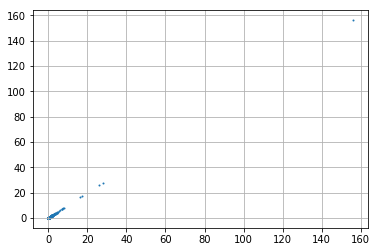

In [35]:
Jon_Exon_RPKM = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/Jon-GTEx/tmp_exon_subset_jc.csv")
Jon_Exon_RPKM.head(2)
JW_Exon = set(ExonRPKM["Name"].values)
JC_Exon = set(Jon_Exon_RPKM["exon_id"].values)
print(len(JW_Exon.intersection(JC_Exon)))
print(len(JW_Exon.difference(JC_Exon)))
print(len(JC_Exon.difference(JW_Exon)))
list(JW_Exon.intersection(JC_Exon))[:10]
print(Jon_Exon_RPKM.shape[1], ExonRPKM.shape[1])
Jon_new_col = ["-".join(x.split(".")) for x in Jon_Exon_RPKM.columns]
Jon_Exon_RPKM.columns = Jon_new_col
SharedSP = []
for SP in GeneRPKM.columns[2:]:
    if SP in Jon_new_col:
        SharedSP.append(SP)
print(len(SharedSP))
X, Y = [], []
#for ENS in list(JW_Exon.intersection(JC_Exon))[:10]:
for ENS in ["ENSG00000158022.6_2"]:
    for SP in SharedSP:
        #print(SP)
        x = ExonRPKM[ExonRPKM["Name"]==ENS][SP].values[0]
        y = Jon_Exon_RPKM[Jon_Exon_RPKM["exon_id"]==ENS][SP].values[0]
        X.append(x)
        Y.append(y)
print(pearsonr(X,Y))
plt.scatter(X, Y, s=1)
#plt.xlim((0,50))
#plt.ylim((0,50))
plt.grid(True)
plt.show()

In [36]:
#ExonRC = pd.read_csv("../data/GTEx/GTEx_180Indiv_exon_rc.txt", delimiter="\t")
#ExonRC.head(2)
ExonRC[ExonRC["Name"] == "ENSG00000158022.6_2"]["GTEX-TMMY-0226-SM-33HBA"]

NameError: name 'ExonRC' is not defined

In [ ]:
ExonRPKM.head(2)
ExonRPKM[ExonRPKM["Name"] == "ENSG00000158022.6_2"]["GTEX-TMMY-0226-SM-33HBA"]

In [462]:
Jon_Gene_RPKM.head(2)

,ROW,GTEX.11ZU8.0011.R4a.SM.5BC6Y,GTEX.11ZVC.0011.R4a.SM.5BC6Z,GTEX.12WSA.0011.R4a.SM.57WB7,GTEX.12WSD.0011.R4b.SM.5LZUA,GTEX.12WSF.0011.R4b.SM.5HL88,GTEX.12WSH.0011.R4a.SM.5GU6K,GTEX.12ZZW.0011.R4a.SM.5DUX9,GTEX.12ZZZ.0011.R4b.SM.5DUV7,GTEX.13112.0011.R4b.SM.5DUXL,...,GTEX.ZVE2.0006.SM.51MRW,GTEX.ZVP2.0005.SM.51MRK,GTEX.ZVT2.0005.SM.57WBW,GTEX.ZVT3.0006.SM.51MT9,GTEX.ZVT4.0006.SM.57WB8,GTEX.ZVTK.0006.SM.57WBK,GTEX.ZVZP.0006.SM.51MSW,GTEX.ZVZQ.0006.SM.51MR8,GTEX.ZXES.0005.SM.57WCB,GTEX.ZXG5.0005.SM.57WCN
0,ENSG00000188157,2.035006,6.942902,9.327048,12.878251,11.581188,3.239905,8.932909,12.278234,15.332375,...,0.374902,0.166505,0.274548,0.422083,0.334501,0.683100,0.148098,0.556412,0.426955,0.313988
1,ENSG00000186891,0.361360,0.267064,0.143500,0.499030,0.813190,0.207169,0.432786,0.273500,0.720403,...,9.935787,1.269453,1.235549,25.135102,10.422676,12.568409,1.762558,16.210703,1.166736,3.744108


1452
1265
165
4433 1585
824
(0.999999995732892, 0.0)


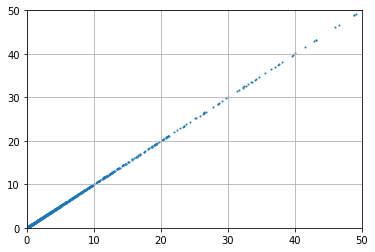

In [465]:
Jon_Gene_RPKM = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/Jon-GTEx/gene-subset-jc.csv")
Jon_Gene_RPKM.head(2)
JW_Gene = set(GeneRPKM["Name"].values)
JC_Gene = set(Jon_Gene_RPKM["ROW"].values)
print(len(JW_Gene.intersection(JC_Gene)))
print(len(JW_Gene.difference(JC_Gene)))
print(len(JC_Gene.difference(JW_Gene)))
list(JW_Gene.intersection(JC_Gene))[:10]
print(Jon_Gene_RPKM.shape[1], GeneRPKM.shape[1])
Jon_new_col = ["-".join(x.split(".")) for x in Jon_Gene_RPKM.columns]
Jon_Gene_RPKM.columns = Jon_new_col
SharedSP = []
for SP in GeneRPKM.columns[2:]:
    if SP in Jon_new_col:
        SharedSP.append(SP)
print(len(SharedSP))
X, Y = [], []
for ENS in list(JW_Gene.intersection(JC_Gene))[:1000]:
    for SP in SharedSP[:2]:
        #print(SP)
        x = GeneRPKM[GeneRPKM["Name"]==ENS][SP].values[0]
        y = Jon_Gene_RPKM[Jon_Gene_RPKM["ROW"]==ENS][SP].values[0]
        X.append(x)
        Y.append(y)
print(pearsonr(X,Y))
plt.scatter(X, Y, s=1)
plt.xlim((0,50))
plt.ylim((0,50))
plt.grid(True)
plt.show()